In [39]:
# model = Doc2Vec(contentcutlist, size=100, window=8, min_count=5, workers=4)
import pandas as pd
import numpy as np
import jieba
#改為中文繁體字典,預設是簡體，可到jieba的GitHub下載
jieba.set_dictionary(r'D:\WordLibrary\JiebaUse\jieba_dict.txt.big') 
#------------------------------
#自製餐廳相關字字典pinlist
with open("D:\Data\csvtest\MyDict.csv") as f:
    mydict=f.read()
#linewords pindict每個字的評分dict
linewords=[{myword:float(line.split(",")[0]) for myword in line.split(",")[1:]}\
           for line in mydict.split("\n") if line.split(",")[0]!=""]
pindict={}
for word in linewords:
    pindict.update(word)
pinlist=list(pindict.keys())
for i in pinlist:
    if i !="":
        jieba.add_word(i)

#-------------------------------

from wordcloud import WordCloud
import random
import json
with open(r"D:\Data\JsonData\TainanFood\bigtable_1.0.json") as f:
    BigAnalyzeTable=json.load(f)

def StopWdFilter(user_input, stop_words):
    """Sanitize using intersection and list.remove()"""
    # Downsides:
    #   - Looping over list while removing from it?
    #     http://stackoverflow.com/questions/1207406/remove-items-from-a-list-while-iterating-in-python
    stop_words = set()
    with open('D:/WordLibrary/JiebaUse/stopwords.txt', 'r', encoding='utf-8') as sw:
        for line in sw:
            stop_words.add(line.strip('\n'))
    for sw in stop_words.intersection(user_input):
        while sw in user_input:
            user_input.remove(sw)

    return user_input
def CutWithFilter(CorpusList):
    result=[]
    for y in [jieba.cut(x) for x in CorpusList]:
        content = StopWdFilter([ _ for _ in y], stopwords)
        result.append(content)
    return result
#所以我選擇所過濾的是跟「文意」比較無關的符號
stopwords = ['〔','〕','／','（','）','「','」','『','』','\n','nan']
#像下面這種比較是傳統文字探勘在過濾字詞可能過濾的一些字詞
#stopwords = ['〔','〕','／','（','）','「','」','『','』','的','就是','這個','可以','一定'\
#             ,'一個','nan','沒有','我們','不是','不用','不是','自己','只要','大家','覺得','因為'\
#             ,'對於','起來','如果','每個','很多','一樣','時候','加上','使用','只是']

goodEatArticle=[{'name':dien["name"],'content':"".join(dien['contentcut'].split(" "))} for dien in BigAnalyzeTable if "非常好吃" in dien["tags"]]
badEatArticle=[{'name':dien["name"],'content':"".join(dien['contentcut'].split(" "))}\
               for dien in BigAnalyzeTable if "非常不好吃" in dien["tags"] or "食物不好吃" in dien["tags"]]

Building prefix dict from D:\WordLibrary\JiebaUse\jieba_dict.txt.big ...
Loading model from cache C:\Users\Java\AppData\Local\Temp\jieba.uf3aabe1eaf7c86dda8313189b0c5c683.cache
Loading model cost 1.123 seconds.
Prefix dict has been built succesfully.


In [40]:
Eat_df=pd.DataFrame(goodEatArticle)
Bad_df=pd.DataFrame(badEatArticle)

Eat = Eat_df.name+ " " + Eat_df.content
Bad  = Bad_df.name+ " " + Bad_df.content

In [41]:
Eat_List = CutWithFilter(Eat)
Bad_List = CutWithFilter(Bad)

In [42]:
import gensim
Lsent = gensim.models.doc2vec.LabeledSentence
def labelizeNews(food, label_type):
    labelized = []
    #enumertate include index
    for i, v in enumerate(food):
        label = '%s_%s' %(label_type,i)
        labelized.append(Lsent(v, [label]))
    return labelized

In [43]:
Train_Eat = labelizeNews(Eat_List,'Eat')
Train_Bad = labelizeNews(Bad_List,'Serve')

In [44]:
size = 400   
model_dm = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, workers=3)
model_dbow = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5,dm=0, workers=3)
Train_All =  Train_Eat + Train_Bad
model_dm.build_vocab(Train_All)
model_dbow.build_vocab(Train_All)

In [45]:
for epoch in range(10):
    
    #總共幾篇文章(假設225) 對1~225做隨機排序的array
    perm = np.random.permutation(len(Train_All))
    
    #將所有的文章隨機順序丟進去訓練 並告知model 共有225個example  5種時?
    model_dm.train([Train_All[x] for x in perm],total_examples=model_dm.corpus_count,epochs=model_dm.iter)
    model_dbow.train([Train_All[x] for x in perm],total_examples=model_dbow.corpus_count,epochs=model_dbow.iter)

In [46]:
def getVecs(model, corpus, size):
    #取出每一個tag(Eat_1.Eat_2...Ser_1.Ser_2....)的向量(docvecs)，並將向量長度全都變成400size
    vecs = [model.docvecs[z.tags[0]].reshape((1, size)) for z in corpus]
    
    return np.concatenate(vecs)

In [47]:
Train_Eat_vecs_dm = getVecs(model_dm, Train_Eat, size)
Train_Eat_vecs_dbow = getVecs(model_dbow, Train_Eat, size)
#將兩種模型的vec上下疊加
Eat_train_vecs = np.hstack((Train_Eat_vecs_dm, Train_Eat_vecs_dbow))

In [48]:
Train_Bad_vecs_dm = getVecs(model_dm, Train_Bad, size)
Train_Bad_vecs_dbow = getVecs(model_dbow, Train_Bad, size)
Bad_train_vecs = np.hstack((Train_Bad_vecs_dm, Train_Bad_vecs_dbow))

In [49]:
from sklearn.cluster import KMeans
#固定random state 隨機初始值 fixed the seed
All_vecs = np.vstack((Eat_train_vecs, Bad_train_vecs))
All_kmeans = KMeans(n_clusters=2, random_state=0).fit(All_vecs)

In [50]:
import gc
gc.collect()

0

In [51]:
All_food_df = Eat_df.copy()
All_food_df = All_food_df.append(Bad_df)

In [52]:
All_List = Eat_List + Bad_List

In [53]:
All_food_df['Cluster'] = All_kmeans.labels_

In [54]:
gc.collect()

7

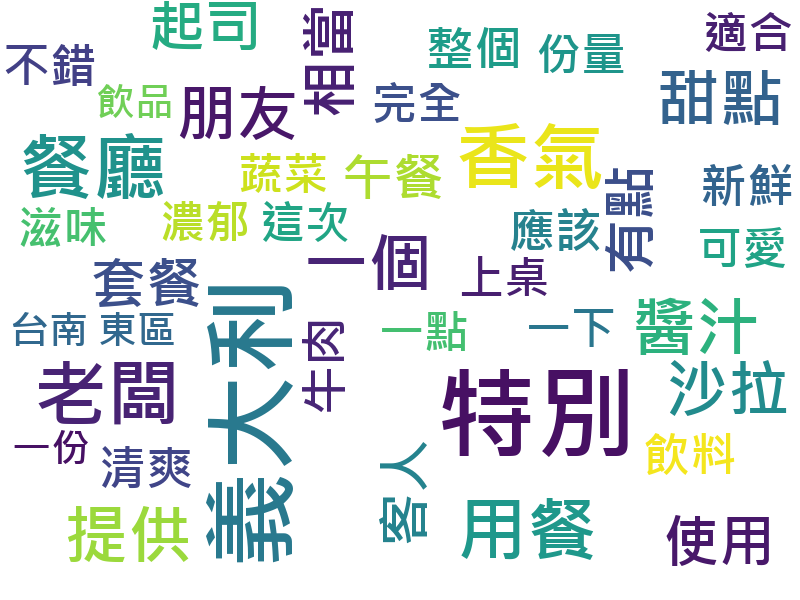

In [75]:
WC_Str=''
for i, x in enumerate(All_kmeans.labels_):
    if x == 0:
        WC_Str += ' '.join(All_List[i])
# from collections import Counter
# stopwords=[i[0] for i in Counter(WC_Str.split(" ")).most_common(50)]
ww = WordCloud(max_font_size=100, relative_scaling=1,max_words=40,width=800, height=600,background_color='white',random_state=0,\
               stopwords=['記者','指出','報導','表示','台灣','今天','可以','一起','除了','自己',
                          '真的','口感','味道','搭配','店家','料理','感覺','餐點','美味','好吃','喜歡','口味','看到','選擇',
                          '覺得','比較','菜單','地址'])\
               .generate(WC_Str)
ww.font_path = 'C:\Windows\Fonts\msjhbd' #微軟正黑體的路徑；字體可以自己設定，預設是英文的遇到中文會讀不出來
ww.to_image()

['吃',
 '麵',
 '台南',
 '好',
 '店家',
 '口感',
 '餐廳',
 '餐點',
 '料理',
 '喔',
 '沙拉',
 '義大利',
 '真的',
 '搭配',
 '喜歡',
 '用餐',
 '味道',
 '小',
 '美食',
 '人',
 '烤',
 '覺得',
 '甜點',
 '套餐',
 '感覺',
 '午餐',
 '包',
 '口味',
 '說',
 '香氣',
 '後',
 '濃湯',
 '選擇',
 '好吃',
 '朋友',
 '起司',
 '店',
 '提供',
 '特別',
 '醬',
 '美味',
 '飯',
 '菜單',
 '再',
 '喝',
 '新鮮',
 '早',
 '牛排',
 '咖啡',
 '元',
 '台南市',
 '比較',
 '唷',
 '囉',
 '飲料',
 '分享',
 '老闆',
 '海鮮',
 '看到',
 '醬汁',
 '一起',
 '飲品',
 '東區',
 '水果',
 '香',
 '一個',
 '鹹',
 '奶油',
 '相當',
 '想',
 '燉',
 '牛肉',
 '濃郁',
 '推薦',
 '中',
 '最',
 '使用',
 '適合',
 '區',
 '服務',
 '法式',
 '肉質',
 '份量',
 '加入',
 '一口',
 '蔬菜',
 '啤酒',
 '主廚',
 '客人',
 '營業時間',
 '風味',
 '清爽',
 '一下',
 '有點',
 '地址',
 '咖哩',
 '讚',
 '電話',
 '巧克力',
 '環境',
 '超',
 '中西區',
 '時間',
 '介紹',
 '滋味',
 '焗',
 '義式',
 '巨鼠',
 '一定',
 '粉絲',
 '生菜',
 '卻',
 '不錯',
 '新',
 '這次',
 '空間',
 '酥脆',
 '整個',
 '吐司',
 '可愛',
 '雞肉',
 '餐',
 '聚餐',
 '做',
 '食材',
 '上桌',
 '蛋糕',
 '店內',
 '座位',
 '一點',
 '應該',
 '披薩',
 '雞',
 '風格',
 '歡迎',
 '專頁',
 '太',
 '酥',
 '廚房',
 '最後',
 '炒',
 '肉',
 '一份',
 '創意',
 '時',
 '附',
 '甜',
 '整體',